# Regression: Ridge Regression (interpretation)

In this notebook, we will run ridge regression multiple times with different L2 penalties to see which one produces the best fit. We will revisit the example of polynomial regression as a means to see the effect of L2 regularization. In particular, we will:
* Use a pre-built implementation of regression (Turi Create) to run polynomial regression
* Use matplotlib to visualize polynomial regressions
* Use a pre-built implementation of regression (Turi Create) to run polynomial regression, this time with L2 penalty
* Use matplotlib to visualize polynomial regressions under L2 regularization
* Choose best L2 penalty using cross-validation.
* Assess the final fit using test data.

We will continue to use the House data from previous notebooks.  (In the next programming assignment for this module, you will implement your own ridge regression learning algorithm using gradient descent.)

In [1]:
# Fire up Turi Create

In [2]:
import turicreate

In [ ]:
# Polynomial regression, revisited

We build on the material from Week 3, where we wrote the function to produce an SFrame with columns containing the powers of a given input. Copy and paste the function `polynomial_sframe` from Week 3:

In [3]:
def polynomial_sframe(feature, degree):
    # assume that degree >= 1
    # initialize the SFrame:
    poly_sframe = turicreate.SFrame()
    # and set poly_sframe['power_1'] equal to the passed feature
    poly_sframe['power_1'] = feature
    # first check if degree > 1
    if degree > 1:
        # then loop over the remaining degrees:
        # range usually starts at 0 and stops at the endpoint-1. We want it to start at 2 and stop at degree
        for power in range(2, degree+1): 
            # first we'll give the column a name:
            name = 'power_' + str(power)
            # then assign poly_sframe[name] to the appropriate power of feature
            poly_sframe[name] = feature ** power
    return poly_sframe

In [ ]:
# Let's use matplotlib to visualize what a polynomial regression looks like on the house data.

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
sales = turicreate.SFrame('kc_house_data.csv')

Finished parsing file /home/ppratikbp/Coursera Machine Learning/C2_4_Ridge Regression/kc_house_data.csv

Parsing completed. Parsed 100 lines in 0.184005 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float,int,float,int,int,float,int,int,int,int,int,int,int,int,int,float,float,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /home/ppratikbp/Coursera Machine Learning/C2_4_Ridge Regression/kc_house_data.csv

Parsing completed. Parsed 21613 lines in 0.131555 secs.

As in Week 3, we will use the sqft_living variable. For plotting purposes (connecting the dots), you'll need to sort by the values of sqft_living. For houses with identical square footage, we break the tie by their prices.

In [6]:
sales = sales.sort(['sqft_living','price'])

Let us revisit the 15th-order polynomial model using the 'sqft_living' input. Generate polynomial features up to degree 15 using `polynomial_sframe()` and fit a model with these features. When fitting the model, use an L2 penalty of `1e-5`:

In [7]:
l2_small_penalty = 1e-5

Note: When we have so many features and so few data points, the solution can become highly numerically unstable, which can sometimes lead to strange unpredictable results.  Thus, rather than using no regularization, we will introduce a tiny amount of regularization (`l2_penalty=1e-5`) to make the solution numerically stable.  (In lecture, we discussed the fact that regularization can also help with numerical stability, and here we are seeing a practical example.)

With the L2 penalty specified above, fit the model and print out the learned weights.

Hint: make sure to add 'price' column to the new SFrame before calling `turicreate.linear_regression.create()`. Also, make sure Turi Create doesn't create its own validation set by using the option `validation_set=None` in this call.

In [9]:
poly15_data = polynomial_sframe(sales['sqft_living'], 15) # use equivalent of `polynomial_sframe`
poly15_features = poly15_data.column_names() # get the name of the features
poly15_data['price'] = sales['price'] # add price to the data since it's the target

model1 = turicreate.linear_regression.create(poly15_data, target = 'price', 
                                           features = poly15_features, l2_penalty=l2_small_penalty,
                                           validation_set=None,verbose=False)
model1.coefficients

name,index,value,stderr
(intercept),None,167924.8608750496,425633.5935256783
power_1,None,103.09094190060318,1985.3921625214987
power_2,None,0.13460456086357306,3.872946455852525
power_3,None,-0.00012907136860666163,0.004171807942906284
power_4,None,5.1892896968328125e-08,2.7637224717881656e-06
power_5,None,-7.771693303686086e-12,1.1847954617558366e-09
power_6,None,1.711448742885639e-16,3.3526723553296204e-13
power_7,None,4.511780043349406e-20,6.234453080526295e-17
power_8,None,-4.788409382618149e-25,7.476873612250956e-21
power_9,None,-2.333434488299772e-28,6.324490740007434e-25


In [10]:
# Observe overfitting

Recall from Week 3 that the polynomial fit of degree 15 changed wildly whenever the data changed. In particular, when we split the sales data into four subsets and fit the model of degree 15, the result came out to be very different for each subset. The model had a *high variance*. We will see in a moment that ridge regression reduces such variance. But first, we must reproduce the experiment we did in Week 3.

First, split the data into split the sales data into four subsets of roughly equal size and call them `set_1`, `set_2`, `set_3`, and `set_4`. Use `.random_split` function and make sure you set `seed=0`. 

In [24]:
(semi_split1, semi_split2) = sales.random_split(.5,seed=0)
(set_1, set_2) = semi_split1.random_split(0.5, seed=0)
(set_3, set_4) = semi_split2.random_split(0.5, seed=0)

Next, fit a 15th degree polynomial on `set_1`, `set_2`, `set_3`, and `set_4`, using 'sqft_living' to predict prices. Print the weights and make a plot of the resulting model.

Hint: When calling `turicreate.linear_regression.create()`, use the same L2 penalty as before (i.e. `l2_small_penalty`).  Also, make sure Turi Create doesn't create its own validation set by using the option `validation_set = None` in this call.

In [26]:
def get_poly_model(set_data, l2_penalty):
    poly15_data = polynomial_sframe(set_data['sqft_living'], 15)
    poly15_features = poly15_data.column_names() # get the name of the features
    poly15_data['price'] = set_data['price'] # add price to the data since it's the target
    model15 = turicreate.linear_regression.create(poly15_data, target = 'price', features = poly15_features, 
                                                l2_penalty=l2_penalty,
                                                validation_set=None,verbose=False)
    return poly15_data, model15
    

def get_coef(set_data, l2_penalty):
    poly15_data, model15 = get_poly_model(set_data, l2_penalty)
    return model15.coefficients

def plot_fitted_line(set_data, l2_penalty):
    poly15_data, model15 = get_poly_model(set_data, l2_penalty)
    return plt.plot(poly15_data['power_1'],poly15_data['price'],'.',
           poly15_data['power_1'], model15.predict(poly15_data),'-')

+---------+-------+-------------------+------------------+
|   name  | index |       value       |      stderr      |
+---------+-------+-------------------+------------------+
| power_1 |  None | 585.8657272438098 | 3474.26925209754 |
+---------+-------+-------------------+------------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


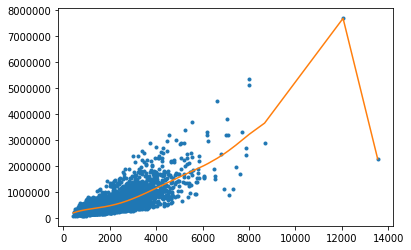

In [27]:
set_1_coef = get_coef(set_1, l2_small_penalty)
print(set_1_coef[set_1_coef['name'] == 'power_1'])
plot_fitted_line(set_1, l2_small_penalty)

+---------+-------+-------------------+-------------------+
|   name  | index |       value       |       stderr      |
+---------+-------+-------------------+-------------------+
| power_1 |  None | 783.4939491597102 | 8291.183156691348 |
+---------+-------+-------------------+-------------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


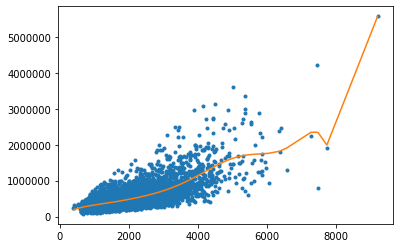

In [29]:
set_2_coef = get_coef(set_2, l2_small_penalty)
print(set_2_coef[set_2_coef['name'] == 'power_1'])
plot_fitted_line(set_2, l2_small_penalty)

+---------+-------+--------------------+--------------------+
|   name  | index |       value        |       stderr       |
+---------+-------+--------------------+--------------------+
| power_1 |  None | -759.2518213099944 | 13631.341494019423 |
+---------+-------+--------------------+--------------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


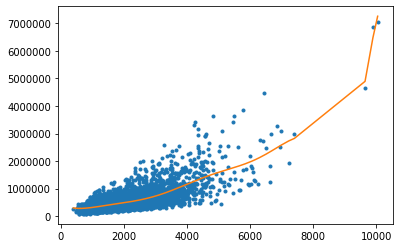

In [30]:
set_3_coef = get_coef(set_3, l2_small_penalty)
print(set_3_coef[set_3_coef['name'] == 'power_1'])
plot_fitted_line(set_3, l2_small_penalty)

# Ridge regression comes to rescue

Generally, whenever we see weights change so much in response to change in data, we believe the variance of our estimate to be large. Ridge regression aims to address this issue by penalizing "large" weights. (Weights of `model15` looked quite small, but they are not that small because 'sqft_living' input is in the order of thousands.)

With the argument `l2_penalty=1e5`, fit a 15th-order polynomial model on `set_1`, `set_2`, `set_3`, and `set_4`. Other than the change in the `l2_penalty` parameter, the code should be the same as the experiment above. Also, make sure Turi Create doesn't create its own validation set by using the option `validation_set = None` in this call.

In [31]:
# The Four curves should differ from one another a lot, as should the coefficients you learned.

In [33]:
l2_new_penalty = 1e5

+---------+-------+-------------------+------------------+
|   name  | index |       value       |      stderr      |
+---------+-------+-------------------+------------------+
| power_1 |  None | 2.587388768322091 | 5228.34987227846 |
+---------+-------+-------------------+------------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


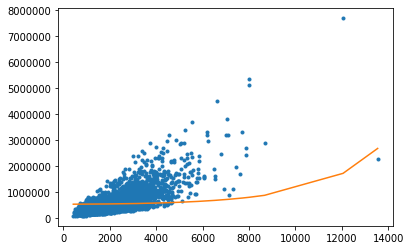

In [35]:
set_1_coef = get_coef(set_1, l2_new_penalty)
print(set_1_coef[set_1_coef['name'] == 'power_1'])
plot_fitted_line(set_1, l2_new_penalty)

+---------+-------+--------------------+--------------------+
|   name  | index |       value        |       stderr       |
+---------+-------+--------------------+--------------------+
| power_1 |  None | 2.0447047675982146 | 11427.070881403295 |
+---------+-------+--------------------+--------------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


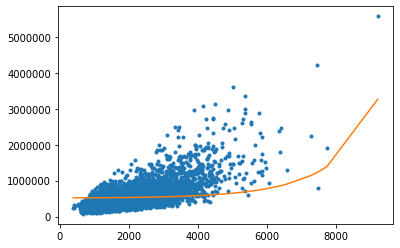

In [36]:
set_2_coef = get_coef(set_2, l2_new_penalty)
print (set_2_coef[set_2_coef['name'] == 'power_1'])
plot_fitted_line(set_2, l2_new_penalty)

+---------+-------+-------------------+--------------------+
|   name  | index |       value       |       stderr       |
+---------+-------+-------------------+--------------------+
| power_1 |  None | 2.268904218589016 | 19002.268589248575 |
+---------+-------+-------------------+--------------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


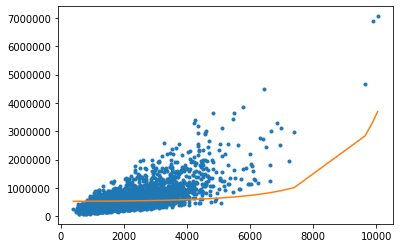

In [37]:
set_3_coef = get_coef(set_3, l2_new_penalty)
print (set_3_coef[set_3_coef['name'] == 'power_1'])
plot_fitted_line(set_3, l2_new_penalty)

+---------+-------+--------------------+--------------------+
|   name  | index |       value        |       stderr       |
+---------+-------+--------------------+--------------------+
| power_1 |  None | 1.9104093778461952 | 10984.374878659588 |
+---------+-------+--------------------+--------------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


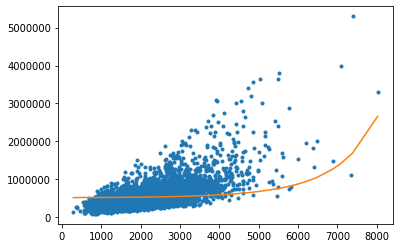

In [38]:
set_4_coef = get_coef(set_4, l2_new_penalty)
print(set_4_coef[set_4_coef['name'] == 'power_1'])
plot_fitted_line(set_4, l2_new_penalty)

In [39]:
# Selecting an L2 penalty via cross-validation

Just like the polynomial degree, the L2 penalty is a "magic" parameter we need to select. We could use the validation set approach as we did in the last module, but that approach has a major disadvantage: it leaves fewer observations available for training. **Cross-validation** seeks to overcome this issue by using all of the training set in a smart way.

We will implement a kind of cross-validation called **k-fold cross-validation**. The method gets its name because it involves dividing the training set into k segments of roughtly equal size. Similar to the validation set method, we measure the validation error with one of the segments designated as the validation set. The major difference is that we repeat the process k times as follows:

Set aside segment 0 as the validation set, and fit a model on rest of data, and evalutate it on this validation set<br>
Set aside segment 1 as the validation set, and fit a model on rest of data, and evalutate it on this validation set<br>
...<br>
Set aside segment k-1 as the validation set, and fit a model on rest of data, and evalutate it on this validation set

After this process, we compute the average of the k validation errors, and use it as an estimate of the generalization error. Notice that  all observations are used for both training and validation, as we iterate over segments of data. 

To estimate the generalization error well, it is crucial to shuffle the training data before dividing them into segments. The package turicreate_cross_validation (see below) has a utility function for shuffling a given SFrame. We reserve 10% of the data as the test set and shuffle the remainder. (Make sure to use `seed=1` to get consistent answer.)

  
_Note:_ For applying cross-validation, we will import a package called `turicreate_cross_validation`. To install it, please run this command on your terminal:

`pip install -e git+https://github.com/Kagandi/turicreate-cross-validation.git#egg=turicreate_cross_validation`

You can find the documentation on this package here: https://github.com/Kagandi/turicreate-cross-validation